In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Q1: Spatial Reasoning & Data Filtering

In [ ]:
delhi_ncr = gpd.read_file("../data/raw/delhi_ncr_region.geojson")
delhi_airshed = gpd.read_file("../data/raw/delhi_airshed.geojson")
print(delhi_ncr.crs)

delhi_ncr_utm = delhi_ncr.to_crs(epsg=32644)
delhi_airshed_utm = delhi_airshed.to_crs(epsg=32644)
combined_region = gpd.overlay(delhi_ncr_utm, delhi_airshed_utm, how="intersection")

In [ ]:
minx, miny, maxx, maxy = delhi_ncr_utm.total_bounds
grid_size = 60000

grid_cells = []

x = minx
while x < maxx:
    y = miny
    while y < maxy:
        grid_cells.append(box(x, y, x + grid_size, y + grid_size))
        y += grid_size
    x += grid_size

grid = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs="EPSG:32644")

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
delhi_ncr_utm.plot(ax=ax, color="none", edgecolor="black")
grid.plot(ax=ax, facecolor="none", edgecolor="red")
plt.title("Delhi NCR with 60km Grid")
plt.savefig("../outputs/figures/grid_plot.png")
plt.show()

In [ ]:
image_folder = "../data/raw/rgb"
image_files = os.listdir(image_folder)

print("Total images before filtering:", len(image_files))

In [ ]:
filtered_images = []

for img in image_files:
    parts = img.replace(".png","").split("_")
    lat = float(parts[-2])
    lon = float(parts[-1])
    
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326")
    point_utm = point.to_crs(epsg=32644)
    
    if combined_region.contains(point_utm.iloc[0]).any():
        filtered_images.append(img)

print("Total images after filtering:", len(filtered_images))

Total images after filtering: 8015


# Q2: Label Construction and Dataset Preparation

In [ ]:
landcover = rasterio.open("../data/raw/worldcover_bbox_delhi_ncr_2021.tif")
print("Raster CRS:", landcover.crs)

Raster CRS: EPSG:4326


In [24]:
patch_size = 128
labels = []
image_paths = []

for img in tqdm(filtered_images):
    parts = img.replace(".png","").split("_")
    lat = float(parts[-2])
    lon = float(parts[-1])
    
    row, col = landcover.index(lon, lat)
    
    half = patch_size // 2
    if (col - half < 0 or row - half < 0 or
        col + half > landcover.width or
        row + half > landcover.height):
        continue
    window = Window(col - half, row - half, patch_size, patch_size)
    
    patch = landcover.read(1, window=window)
    
    values, counts = np.unique(patch, return_counts=True)
    dominant = values[np.argmax(counts)]
    
    labels.append(dominant)
    image_paths.append(os.path.join(image_folder, img))

100%|██████████| 8015/8015 [00:04<00:00, 1997.15it/s]


In [25]:
esa_mapping = {
    10: "Vegetation",
    20: "Vegetation",
    30: "Vegetation",
    40: "Cropland",
    50: "Built-up",
    60: "Others",
    70: "Others",
    80: "Water",
    90: "Water",
    95: "Others",
    100: "Others"
}

simple_labels = [esa_mapping.get(l, "Others") for l in labels]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    simple_labels,
    test_size=0.4,
    random_state=42,
    stratify=simple_labels
)

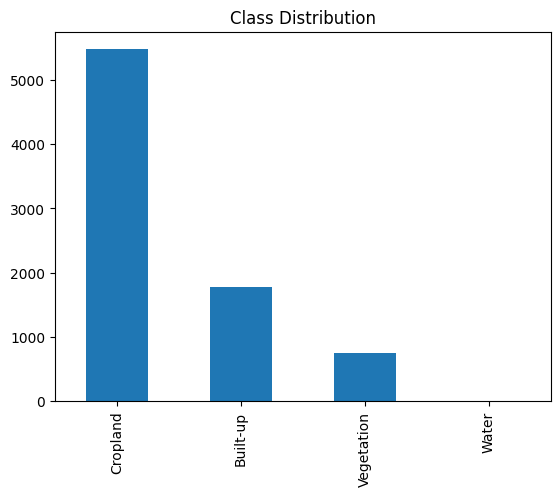

In [27]:
pd.Series(simple_labels).value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.savefig("../outputs/figures/class_distribution.png")
plt.show()

# Q3: Model Training & Supervised Evaluation

In [28]:
unique_labels = sorted(list(set(simple_labels)))
label_map = {label: i for i, label in enumerate(unique_labels)}

class LandUseDataset(Dataset):
    def __init__(self, image_paths, labels, label_map, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.label_map = label_map
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = plt.imread(self.image_paths[idx])
        if self.transform:
            img = self.transform(img)
        label = self.label_map[self.labels[idx]]
        return img, label

In [29]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = LandUseDataset(X_train, y_train, label_map, transform)
test_dataset = LandUseDataset(X_test, y_test, label_map, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [30]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(unique_labels))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

e:\GIT\AI Sustainability Project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\GIT\AI Sustainability Project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(5):
    model.train()
    
    for images, labels_batch in test_loader:
        images = images.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
    
    print("Epoch:", epoch, "Loss:", loss.item())

In [ ]:
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for images, labels_batch in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_true.extend(labels_batch.cpu().numpy())

In [ ]:
accuracy = accuracy_score(all_true, all_preds)
f1 = f1_score(all_true, all_preds, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)

In [ ]:
torch.save(model.state_dict(), "../outputs/models/resnet18_landuse.pth")